In [1]:
import pickle
import string
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import cross_validation
from sklearn.externals import joblib

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.optimizers
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
% matplotlib inline

C:\Users\Born_2_Code\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


#### Load training data

In [2]:
df = pd.read_json('train_X_languages_homework.json.txt', lines=True)
df_y = pd.read_json('train_y_languages_homework.json.txt', lines=True)

### Clean data

#### Clean data and remove punctuations

In [3]:
df['text_cleaned'] = df['text'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

#### create output mapping dictionary

In [4]:
labels = np.unique(df_y.classification)
val_to_cat = {}
index = 0
for label in labels:
    val_to_cat[index] = label
    index += 1
with open("val_to_cat.pkl", 'wb') as f:
    pickle.dump(val_to_cat, f, pickle.HIGHEST_PROTOCOL)

#### convert labels into values

In [5]:
le = LabelEncoder()
df_y_values = pd.DataFrame(le.fit_transform(df_y),columns=["label"])

C:\Users\Born_2_Code\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### join data and labels dataframes

In [6]:
df_new = df.join(df_y_values)

### Feature Engineering

#### extract features - top 100 words from each language

In [7]:
word_list = []
for val in np.unique(df_y_values.label):
    text = df_new[df_new.label == val]['text_cleaned'].str.cat(sep='')
    table = str.maketrans({key: None for key in string.punctuation})
    new_text = text.translate(table) 
    common = Counter(new_text.lower().split()).most_common(100)
    words = [key for key, val in common]
    word_list.extend(words)

#### get unique words

In [8]:
word_list = set(word_list)

#### create pipeline to join features top 100 words from each language category and language alphabets

In [9]:
pipeline = Pipeline([
    ('feats', FeatureUnion([
        ('char', CountVectorizer(analyzer='char')),
       ('words', CountVectorizer(vocabulary=word_list))
    ]))
])

#### extract features by calling fit transform

In [10]:
data = pipeline.fit_transform(df_new["text_cleaned"],y=df_new["label"])

#### save pipline to use with test data

In [11]:
joblib.dump(pipeline, 'pipeline.pkl') 

['pipeline.pkl']

#### test train split - test size zero as test data is provided

In [12]:
X_train, _ , y_train, _ = cross_validation.train_test_split(data, df_new["label"], test_size=0)

### define a model

In [13]:
input_size = X_train.shape[1]
# convert output y to categorical 

def convert_to_categorical(data):
    return to_categorical(data.as_matrix())

y_binary = convert_to_categorical(y_train)

#### define model

In [14]:
model = Sequential()
model.add(Dense(500,input_dim=input_size,kernel_initializer="glorot_uniform",activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(200,kernel_initializer="glorot_uniform",activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(y_binary[0]),kernel_initializer="glorot_uniform",activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=model_optimizer, metrics=['accuracy'])

#### define callback for earlystopping

In [15]:
callback = [EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')]

#### train the model

In [16]:
history = model.fit(X_train.toarray(),y_binary, epochs=50, validation_split=0.20, shuffle=True, batch_size=64,callbacks=callback)

Train on 100312 samples, validate on 25079 samples
Epoch 1/50
100312/100312 [==============================] - 162s 2ms/step - loss: 1.7206 - acc: 0.5783 - val_loss: 1.1298 - val_acc: 0.7088
Epoch 2/50
100312/100312 [==============================] - 164s 2ms/step - loss: 1.1552 - acc: 0.6999 - val_loss: 0.9750 - val_acc: 0.7376
Epoch 3/50
100312/100312 [==============================] - 165s 2ms/step - loss: 1.0596 - acc: 0.7197 - val_loss: 0.9714 - val_acc: 0.7401
Epoch 4/50
100312/100312 [==============================] - 167s 2ms/step - loss: 1.0150 - acc: 0.7297 - val_loss: 0.9395 - val_acc: 0.7460
Epoch 5/50
100312/100312 [==============================] - 170s 2ms/step - loss: 0.9916 - acc: 0.7342 - val_loss: 0.9473 - val_acc: 0.7414
Epoch 6/50
100312/100312 [==============================] - 175s 2ms/step - loss: 0.9673 - acc: 0.7392 - val_loss: 0.9329 - val_acc: 0.7466
Epoch 7/50
100312/100312 [==============================] - 170s 2ms/step - loss: 0.9523 - acc: 0.7430 - val_

### visualize model

In [17]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

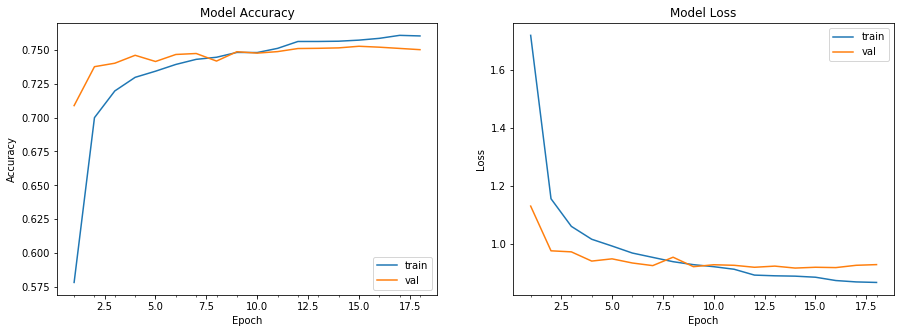

In [18]:
plot_model_history(history)

In [19]:
model.save('language_identification_model.h5')